In [1]:
import asyncio
import aiohttp
import json
import os
from tqdm.notebook import tqdm

In [2]:
NUM_KIDS = 100 # per story

HN_STORIES_JSON = '../sampled_hn_stories_dataset.json' # raw stories data, used to fetch comments from kid ids
HN_COMMENTS_JSON = '../sampled_hn_comments_dataset.json' # store raw stories + comments
HN_COMMENTS_CSV = 'sampled_full_hn_comments.csv' # converted from json to csv
HN_COMMENTS_SAMPLED_CSV = 'sampled_400_hn_comments_ground_truth.csv' # uniformly sampled comments for ground truth

# Define the base URL for the Hacker News API
BASE_URL = 'https://hacker-news.firebaseio.com/v0'

DEPTH = 1 # comments depth

In [30]:
async def get_top_story_ids(session):
    async with session.get(f'{BASE_URL}/topstories.json') as response:
        return await response.json()

async def get_item(session, item_id):
    async with session.get(f'{BASE_URL}/item/{item_id}.json') as response:
        return await response.json()

async def get_kids_hierarchical(session, item, depth=DEPTH):
    if 'kids' not in item or depth <= 0:
        return []

    kids_hierarchy = []
    tasks = []
    for kid_id in item['kids'][:NUM_KIDS]:
        tasks.append(get_item(session, kid_id))

    kids = await asyncio.gather(*tasks)
    for kid in kids:
        if kid:
            kid_data = {
                'id': kid.get('id'),
                'text': kid.get('text'),
                'time': kid.get('time'),
                'author': kid.get('by'),
                'depth': DEPTH - depth + 1,
                'children': await get_kids_hierarchical(session, kid, depth - 1)
            }
            kids_hierarchy.append(kid_data)
    return kids_hierarchy

def load_progress(filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    return {'processed_story_max_id': -1, 'stories': []}

def save_progress(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

async def retrieve_stories_comments(stories_source_filename, comments_dest_filename):
    stories_dest = load_progress(comments_dest_filename)
    progress_story_max_id = stories_dest['processed_story_max_id']
    stories_comments_dest = stories_dest['stories']
    curr_num_stories = len(stories_comments_dest)

    stories_source = load_progress(stories_source_filename)
    total_num_stories = len(stories_source['stories'])

    async with aiohttp.ClientSession() as session:
        pbar = tqdm(total=total_num_stories, desc="Fetching comments from stories")
        pbar.update(curr_num_stories)

        for story in stories_source['stories']:
            try:
                if story['id'] <= progress_story_max_id:
                    continue

                story['kids_text'] = await get_kids_hierarchical(session, story, depth=DEPTH)
                stories_comments_dest.append(story)

                pbar.update(1)
                progress_story_max_id = story['id']
                save_progress({'processed_story_max_id': progress_story_max_id,
                               'stories': stories_comments_dest}, comments_dest_filename)
            except Exception as e:
                print(f"Error processing story {story['id']}: {e}")
                save_progress({'processed_story_max_id': progress_story_max_id,
                               'stories': stories_comments_dest}, comments_dest_filename)
        pbar.close()
    return stories_comments_dest

In [33]:
try:
    # Load the original JSON file
    with open(HN_STORIES_JSON, "r") as file:
        data = json.load(file)

    # Process the stories and fetch comments
    processed_data = await retrieve_stories_comments(HN_STORIES_JSON, HN_COMMENTS_JSON)

    print('Done')
except Exception as e:
    print(f"Error: {e}")

Fetching comments from stories:   0%|          | 0/225 [00:00<?, ?it/s]

Done


# counting

In [ ]:
def count_comments(data):
    return len(data), sum(len(story['kids_text']) for story in data)

num_stories, num_comments = count_comments(processed_data)
print(f"Total number of stories: {num_stories}")
print(f"Total number of comments: {num_comments}")

# convert from json to csv

In [35]:
import json
import csv
import html
from datetime import datetime
import re
from bs4 import BeautifulSoup

def read_json_file(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def extract_github_urls(text):
    github_url_pattern = r"https://github\.com/[a-zA-Z0-9-]+/[a-zA-Z0-9-_.]+(?:/(?:issues|pull)/\d+)?"
    return list(set(re.findall(github_url_pattern, text)))

def is_github_repo_or_issue(url):
    if not url.startswith("https://github.com/"):
        return "Not GitHub"
    if "/issues/" in url:
        return "GitHub Issue"
    if "/pull/" in url:
        return "GitHub PR"
    return "GitHub Repo"

def unix_to_datetime(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')

def clean_html(html_text):
    if html_text is None:
        return ''
    soup = BeautifulSoup(html_text, 'html.parser')
    return soup.get_text(separator=' ', strip=True)

def flatten_comments(comments, discussion_id, title, url, discussion_date, parent_id=None, depth=0):
    flattened = []
    if not isinstance(comments, list):
        print(f"Warning: comments is not a list. Type: {type(comments)}")
        return flattened

    for i, comment in enumerate(comments):
        if not isinstance(comment, dict):
            print(f"Warning: comment {i} is not a dict. Type: {type(comment)}")
            continue

        comment_id = comment.get('id', '')
        comment_text = comment.get('text')
        if comment_text is None:
            print(f"Warning: comment {comment_id} has None text")
            comment_text = ''
        else:
            comment_text = clean_html(comment_text)
        comment_date = unix_to_datetime(comment.get('time', 0))
        comment_author = comment.get('author', '')

        flattened.append({
            'discussion_id': discussion_id,
            'title': title,
            'url': url,
            'discussion_date': discussion_date,
            'comment_id': comment_id,
            'parent_id': parent_id,
            'depth': depth,
            'comment_text': comment_text,
            'comment_date': comment_date,
            'comment_author': comment_author,
        })

        children = comment.get('children', [])
        if isinstance(children, list):
            flattened.extend(flatten_comments(children, discussion_id, title, url, discussion_date, comment_id, depth + 1))
        else:
            print(f"Warning: children for comment {comment_id} is not a list. Type: {type(children)}")

    return flattened

def process_stories(discussions):
    rows = []
    github_urls = set()

    for i, discussion in enumerate(discussions['stories']):
        discussion_id = discussion.get('id')
        title = discussion.get('title', '')
        url = discussion.get('url', '')
        discussion_date = unix_to_datetime(discussion.get('time', 0))

        print(f"Processing discussion {i+1}: ID {discussion_id}, Title: {title[:30]}...")

        github_urls.update(extract_github_urls(title))
        github_urls.update(extract_github_urls(url))

        comments_hierarchy = discussion.get('kids_text', None)
        if comments_hierarchy is not None:
            print(f"  Found {len(comments_hierarchy)} top-level comments")
            for j, comment in enumerate(comments_hierarchy):
                comment_text = comment.get('text', 'N/A')
                comment_text_preview = comment_text[:30] if comment_text is not None else 'None'
                print(f"    Comment {j+1}: ID {comment.get('id', 'N/A')}, Author: {comment.get('author', 'N/A')}, Text: {comment_text_preview}...")
            rows.extend(flatten_comments(comments_hierarchy, discussion_id, title, url, discussion_date))
        else:
            print("  No comments found for this discussion")
            rows.append({
                'discussion_id': discussion_id,
                'title': title,
                'url': url,
                'discussion_date': discussion_date,
                'comment_id': '',
                'parent_id': '',
                'depth': 0,
                'comment_text': '',
                'comment_date': '',
                'comment_author': '',
            })

    print(f"Processed {len(discussions['stories'])} discussions, found {len(rows)} total comments")
    return rows, github_urls

def write_csv(filename, data, fieldnames):
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)


In [36]:
chatgpt_data = read_json_file(HN_COMMENTS_JSON)

comments_rows, comments_github_urls = process_stories(chatgpt_data)

fieldnames = [
    'discussion_id',
    'title',
    'url',
    'discussion_date',
    'comment_id',
    'parent_id',
    'depth',
    'comment_text',
    'comment_date',
    'comment_author',
]

write_csv(HN_COMMENTS_CSV, comments_rows, fieldnames)

Processing discussion 1: ID 31533180, Title: Codeball – AI-powered code rev...
  Found 20 top-level comments
    Comment 1: ID 31534424, Author: apugoneappu, Text: Explanation of results for non...
    Comment 2: ID 31535661, Author: gombosg, Text: I&#x27;m a bit skeptical here....
    Comment 3: ID 31535295, Author: donkarma, Text: I would never use something li...
    Comment 4: ID 31535829, Author: mchusma, Text: I think I like this better exp...
    Comment 5: ID 31533864, Author: videlov, Text: Creator of Codeball here, some...
    Comment 6: ID 31536601, Author: oefrha, Text: For open contribution projects...
    Comment 7: ID 31533983, Author: mdaniel, Text: I can&#x27;t tell if this is a...
    Comment 8: ID 31535337, Author: Imnimo, Text: &gt;Codeball uses a Multi-laye...
    Comment 9: ID 31535554, Author: tehsauce, Text: I would be a bit concerned abo...
    Comment 10: ID 31534013, Author: danielmarkbruce, Text: Looks awesome.<p>Tone down the...
    Comment 11: ID 31535573,

# stratified sampling

In [17]:
import pandas as pd
import numpy as np

def stratified_sample_with_min_per_story(csv_file, num_samples, output_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Group by discussion_id (which represents each story)
    grouped = df.groupby('discussion_id')

    # Initialize an empty DataFrame to store the sampled data
    sampled_df = pd.DataFrame()

    # Step 1: Ensure each story gets at least one comment
    for name, group in grouped:
        if len(group) > 1:
            sampled_df = pd.concat([sampled_df, group.sample(n=1, random_state=42)])
        else:
            sampled_df = pd.concat([sampled_df, group])

    # Step 2: Calculate the remaining number of comments to sample
    remaining_samples = num_samples - len(sampled_df)

    if remaining_samples > 0:
        # Step 3: Sample the remaining comments proportionally to the size of each group
        proportion = remaining_samples / (len(df) - len(sampled_df))

        remaining_sampled = grouped.apply(lambda x: x.sample(frac=proportion, random_state=42) if len(x) > 1 else pd.DataFrame())
        remaining_sampled = remaining_sampled.reset_index(drop=True)

        # Combine the guaranteed 1 comment samples with the remaining proportional samples
        sampled_df = pd.concat([sampled_df, remaining_sampled])

    # Ensure the final number of samples matches exactly num_samples
    if len(sampled_df) > num_samples:
        sampled_df = sampled_df.sample(n=num_samples, random_state=42)

    # Save the sampled data to a new CSV file
    sampled_df.to_csv(output_file, index=False)

# Example usage:
stratified_sample_with_min_per_story(HN_COMMENTS_CSV, 400, HN_COMMENTS_SAMPLED_CSV)


C:\Users\prach\AppData\Local\Temp\ipykernel_20332\3447964177.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  remaining_sampled = grouped.apply(lambda x: x.sample(frac=proportion, random_state=42) if len(x) > 1 else pd.DataFrame())


## show comments statistics

In [18]:
import pandas as pd

def get_comment_statistics(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Group by 'discussion_id' and count the number of comments in each story
    comment_counts = df.groupby('discussion_id').size().reset_index(name='num_comments')

    # Calculate overall statistics
    total_stories = comment_counts['discussion_id'].nunique()
    total_comments = comment_counts['num_comments'].sum()
    max_comments = comment_counts['num_comments'].max()
    min_comments = comment_counts['num_comments'].min()
    avg_comments = comment_counts['num_comments'].mean()

    # Print the statistics
    print(f"Total number of stories: {total_stories}")
    print(f"Total number of comments: {total_comments}")
    print(f"Average number of comments per story: {avg_comments:.2f}")
    print(f"Max number of comments in a story: {max_comments}")
    print(f"Min number of comments in a story: {min_comments}")

    # Return the DataFrame containing the number of comments per story
    return comment_counts


In [19]:
# Example usage:
comment_stats = get_comment_statistics(HN_COMMENTS_CSV)
print(comment_stats)

Total number of stories: 220
Total number of comments: 3928
Average number of comments per story: 17.85
Max number of comments in a story: 100
Min number of comments in a story: 1
     discussion_id  num_comments
0         31533180            20
1         31555920            19
2         31662560            28
3         31776740             2
4         31934400             7
..             ...           ...
215       40189560             2
216       40215100             4
217       40259100            11
218       40265420             1
219       40291780             4

[220 rows x 2 columns]


In [20]:
# Example usage:
comment_stats = get_comment_statistics(HN_COMMENTS_SAMPLED_CSV)
print(comment_stats)

Total number of stories: 220
Total number of comments: 391
Average number of comments per story: 1.78
Max number of comments in a story: 6
Min number of comments in a story: 1
     discussion_id  num_comments
0       31533180.0             2
1       31555920.0             2
2       31662560.0             2
3       31776740.0             1
4       31934400.0             1
..             ...           ...
215     40189560.0             1
216     40215100.0             1
217     40259100.0             2
218     40265420.0             1
219     40291780.0             1

[220 rows x 2 columns]


## plot no. comments per story

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comment_distribution(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Group by 'discussion_id' and count the number of comments in each story
    comment_counts = df.groupby('discussion_id').size().reset_index(name='num_comments')

    # Sort by number of comments for better visualization
    comment_counts = comment_counts.sort_values(by='num_comments', ascending=False)

    # Plotting the distribution of comments per story
    plt.figure(figsize=(10, 6))
    sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')

    # Set the plot title and labels
    plt.title('Number of Comments per Story (discussion_id)', fontsize=14)
    plt.xlabel('Discussion ID (Story)', fontsize=12)
    plt.ylabel('Number of Comments', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()

C:\Users\prach\AppData\Local\Temp\ipykernel_20332\1638619403.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')


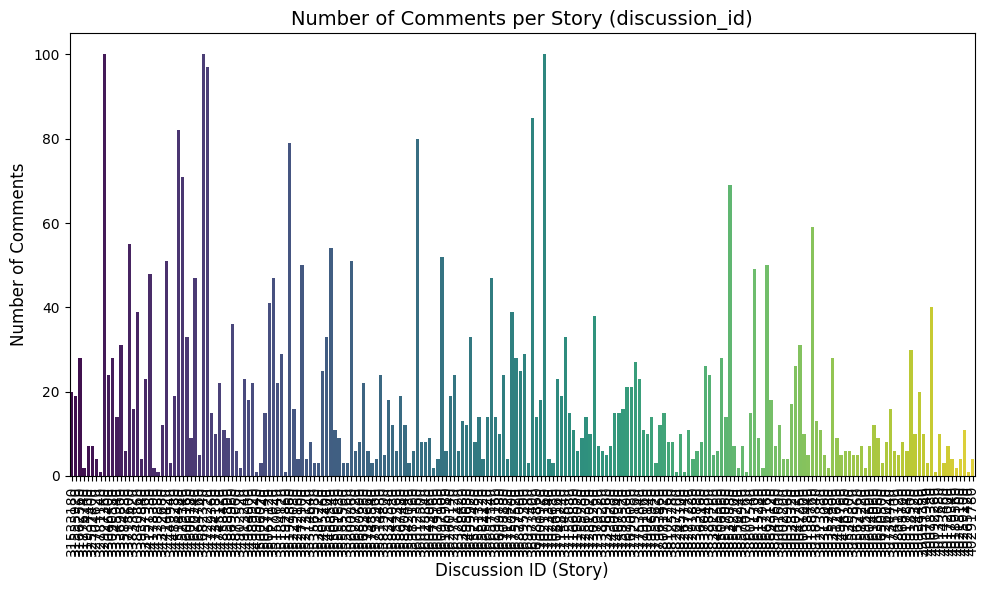

In [22]:
# Example usage:
plot_comment_distribution(HN_COMMENTS_CSV)

C:\Users\prach\AppData\Local\Temp\ipykernel_20332\1638619403.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')


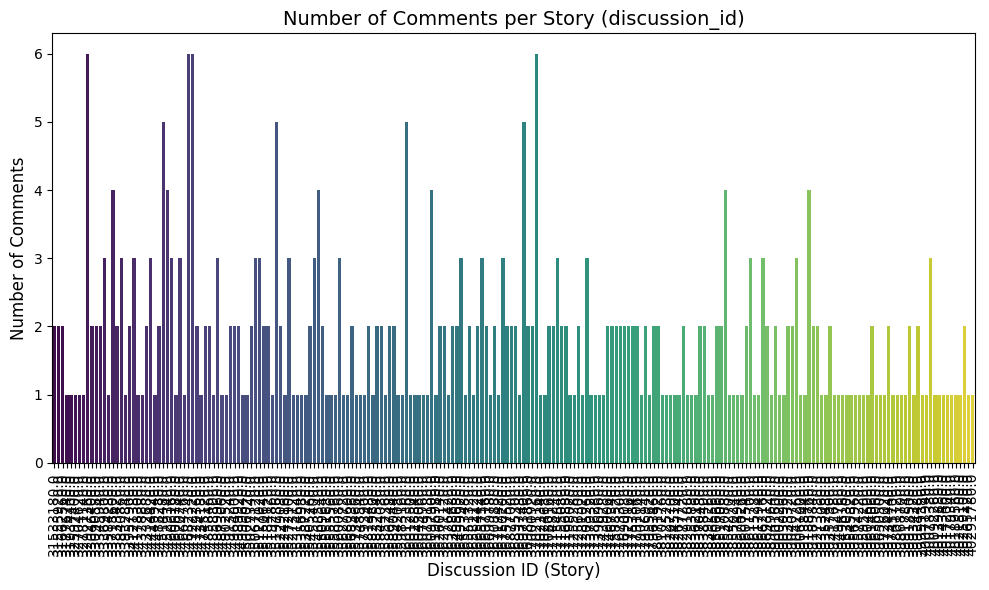

In [23]:
# Example usage:
plot_comment_distribution(HN_COMMENTS_SAMPLED_CSV)